In [53]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import datetime
import numpy as np
import time
import pandas as pd
import getpass

In [115]:
class Sun:
    def __init__(self, SEA, AZ):
        self.r = 50
        self.x = self.r * math.cos(SEA)*math.cos(AZ)
        self.y = self.r * math.cos(SEA)*math.sin(AZ)
        self.z = self.r * math.sin(SEA)
    def position(self):
        self.x = self.r * math.cos(SEA)*math.cos(AZ)
        self.y = self.r * math.cos(SEA)*math.sin(AZ)
        self.z = self.r * math.sin(SEA)
        position = [self.x,self.y, self.z]
        return np.array(position) 
class Flower:
    def __init__(self, x = None, y = None, z = None):
        if x is None:
            self.x = 0
        else:
            self.x = x
        if y is None:
            self.y = 0
        else:
            self.y = y
        if z is None:
            self.z = 0
        else:
            self.z = z
    def position(self):
        return np.array([self.x, self.y, self.z])
class Cloude:
    def __init__(self, speed_of_wind = None):
        self.x_offset = 10
        self.y_offset = 10
        self.center = [-7,10,5]
        self.x1 = self.x2 = self.center[0]+self.x_offset
        self.x3 = self.x4 = self.center[0]-self.x_offset
        self.y1 = self.y3 = self.center[1]+self.y_offset
        self.y2 = self.y4 = self.center[1]-self.y_offset
        self.z1 = self.z2 = self.z3 = self.z4 = 5
        if speed_of_wind is None:
            self.speed_of_wind_x = 1
            self.speed_of_wind_y = 1
            self.speed_of_wind_z = 0
        else:
            self.speed_of_wind_x = speed_of_wind[0]
            self.speed_of_wind_y = speed_of_wind[1]
            self.speed_of_wind_z = speed_of_wind[2]
    def position(self):
        return np.array([[self.x1, self.y1,self.z1],  [self.x2, self.y2,self.z2], 
                         [self.x3, self.y3,self.z3],  [self.x4, self.y4,self.z4] ])
    def center_position(self):
        return np.array(self.center)
    def move(self):
        #Сделать для этого цикл потом
        
        self.x1 = self.x1 + self.speed_of_wind_x
        self.x2 = self.x2 + self.speed_of_wind_x
        self.x3 = self.x3 + self.speed_of_wind_x
        self.x4 = self.x4 + self.speed_of_wind_x
        
        self.y1 = self.y1 + self.speed_of_wind_y
        self.y2 = self.y2 + self.speed_of_wind_y
        self.y3 = self.y3 + self.speed_of_wind_y
        self.y4 = self.y4 + self.speed_of_wind_y
        
        self.z1 = self.z1 + self.speed_of_wind_z
        self.z2 = self.z2 + self.speed_of_wind_z
        self.z3 = self.z3 + self.speed_of_wind_z
        self.z4 = self.z4 + self.speed_of_wind_z
class Lamp:
    def __init__(self):
        self.ligth = False
    def on(self):
        self.ligth = True
    def off(self):
        self.ligth = False
    def check(self):
        if(self.ligth):
            return "ON"
        else:
            return "OFF"

In [123]:
def update_field(sun, cloud):
    cloude.move()
    sun.position()
def getSEA(latitude = None, longitude = None,  utc_offset = None, date = None, hour = None, minute = None):
    if latitude is None:
        latitude = 55.55
    if longitude is None:
        longitude = 37.37
    if utc_offset is None:
        utc_offset = 3
    date = datetime.datetime.now().timetuple()
    if hour is None:
        hour = date[3]
    if minute is None:
        minute = date[4]


    hour_minute = (hour + minute / 60) - utc_offset
    day_of_year = date[7]

    g = (360 / 365.25) * (day_of_year + hour_minute / 24)

    g_radians = math.radians(g)

    declination = 0.396372 - 22.91327 * math.cos(g_radians) + 4.02543 * math.sin(g_radians) - 0.387205 * math.cos(
        2 * g_radians) + 0.051967 * math.sin(2 * g_radians) - 0.154527 * math.cos(3 * g_radians) + 0.084798 * math.sin(
        3 * g_radians)

    time_correction = 0.004297 + 0.107029 * math.cos(g_radians) - 1.837877 * math.sin(g_radians) - 0.837378 * math.cos(
        2 * g_radians) - 2.340475 * math.sin(2 * g_radians)

    SHA = (hour_minute - 12) * 15 + longitude + time_correction

    if (SHA > 180):
        SHA_corrected = SHA - 360
    elif (SHA < -180):
        SHA_corrected = SHA + 360
    else:
        SHA_corrected = SHA

    lat_radians = math.radians(latitude)
    d_radians = math.radians(declination)
    SHA_radians = math.radians(SHA)

    SZA_radians = math.acos(
        math.sin(lat_radians) * math.sin(d_radians) + math.cos(lat_radians) * math.cos(d_radians) * math.cos(
            SHA_radians))

    SZA = math.degrees(SZA_radians)

    SEA = 90 - SZA
    return SEA
def getAZ(latitude = None, longitude = None,  utc_offset = None, date = None, hour = None, minute = None):
    if latitude is None:
        latitude = 55.55
    if longitude is None:
        longitude = 37.37
    if utc_offset is None:
        utc_offset = 3
    date = datetime.datetime.now().timetuple()
    if hour is None:
        hour = date[3]
    if minute is None:
        minute =date[4]
        
    hour_minute = (hour + minute / 60) - utc_offset
    day_of_year = date[7]

    g = (360 / 365.25) * (day_of_year + hour_minute / 24)

    g_radians = math.radians(g)

    declination = 0.396372 - 22.91327 * math.cos(g_radians) + 4.02543 * math.sin(g_radians) - 0.387205 * math.cos(
        2 * g_radians) + 0.051967 * math.sin(2 * g_radians) - 0.154527 * math.cos(3 * g_radians) + 0.084798 * math.sin(
        3 * g_radians)

    time_correction = 0.004297 + 0.107029 * math.cos(g_radians) - 1.837877 * math.sin(g_radians) - 0.837378 * math.cos(
        2 * g_radians) - 2.340475 * math.sin(2 * g_radians)

    SHA = (hour_minute - 12) * 15 + longitude + time_correction

    if (SHA > 180):
        SHA_corrected = SHA - 360
    elif (SHA < -180):
        SHA_corrected = SHA + 360
    else:
        SHA_corrected = SHA

    lat_radians = math.radians(latitude)
    d_radians = math.radians(declination)
    SHA_radians = math.radians(SHA)

    SZA_radians = math.acos(
        math.sin(lat_radians) * math.sin(d_radians) + math.cos(lat_radians) * math.cos(d_radians) * math.cos(
            SHA_radians))

    SZA = math.degrees(SZA_radians)

    cos_AZ = (math.sin(d_radians) - math.sin(lat_radians) * math.cos(SZA_radians)) / (
    math.cos(lat_radians) * math.sin(SZA_radians))

    AZ_rad = math.acos(cos_AZ)
    AZ = math.degrees(AZ_rad)

    # You may need to use this check github description
    #AZ_NORTH_TO_EAST = 360 - AZ

    return AZ
def intersection(Line, Plane):
    # Points in Segment: Pn  Points in Plane: Qn
    P0, P1     = np.array(Segment.coords)
    Q0, Q1, Q2 = np.array(Plane.exterior)[:-1]   

    # vectors in Plane
    vector_plane_1 = Q1 - Q0
    vector_plane_2 = Q2 - Q0

    # vector normal to Plane
    n  = np.cross(vector_plane_1, vector_plane_2)/np.linalg.norm(np.cross(vector_plane_1, vector_plane_2))
    u = P1 - P0 # Segment's direction vector 
    w = P0 - Q0 # vector from plane ref point to segment ref point

    ## Tests parallelism
    if np.dot(n, u) == 0:
        return None
    else:
        ## Si is the scalar where P(Si) = P0 + Si*u lies in Plane
        Si = np.dot(-n, w) / np.dot(n, u)
        intersection = P0 + Si * u
        return intersection
def check_intersection(sun, cloude, flower):
    l = LineString([flower.position(),sun.position()])
    p = Polygon(cloude.position()[0:3])
    c = intersect3D_SegmentPlane(l, p)
    if (cloude.x3<= c[0]<= cloude.x1 and cloude.y2 <= c[1] <= cloude.y1 ):
        return True
    return False

-0.7510870200006811
0.47337145607870906
False


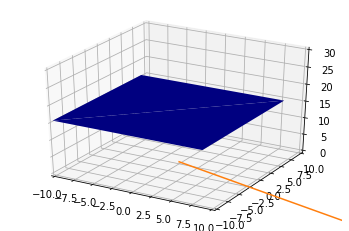

In [124]:
SEA = math.radians(getSEA())
print(SEA)
AZ = math.radians(getAZ())
print(AZ)
sun = Sun(SEA, AZ)
cloude = Cloude()
flower = Flower()
#print(sun.position())

#print(cloude.position())
print(check_intersection(sun,cloude,flower))
x = [cloude.x1, cloude.x2, cloude.x3, cloude.x4]
y = [cloude.y1, cloude.y2, cloude.y3, cloude.y4]
z = [cloude.z1, cloude.z2, cloude.z3, cloude.z4]
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax.plot_trisurf(x,y,z, cmap = cm.jet)
ax.plot([flower.position()[0],sun.position()[0]],
        [flower.position()[1],sun.position()[1]], 
        [flower.position()[2],sun.position()[2]])
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(0,30)
plt.show()

Введите широту(Москва - 55.7522): 
Введите долготу(Москва - 37.6156): 
Введите временной сдвиг(Москва - 3 часа): 
Введите время в часах: 
Введите время в минутах: 
Коордитаны солнца: [ 32.52849099  16.66156736 -34.12168588]
Координаты центра облака: [-7 10  5]


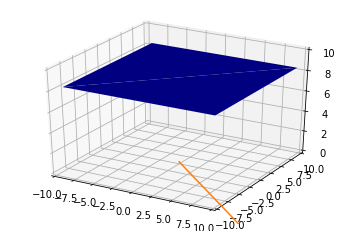

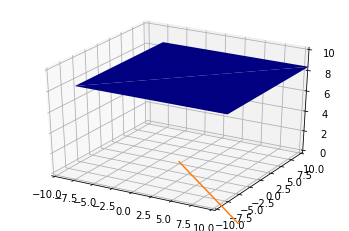

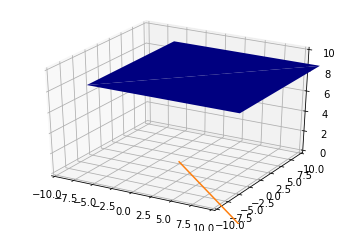

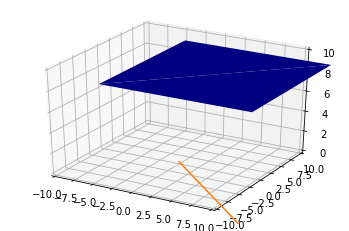

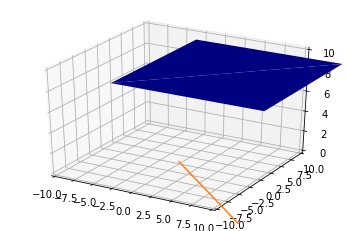

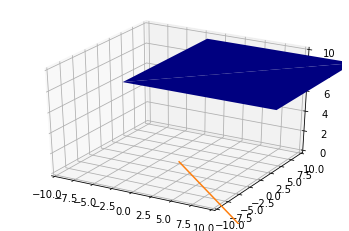

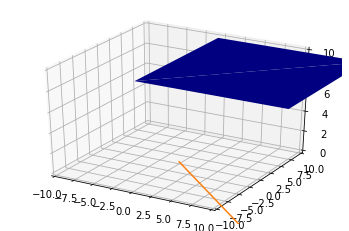

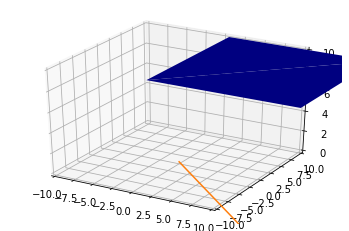

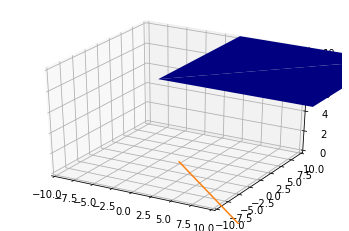

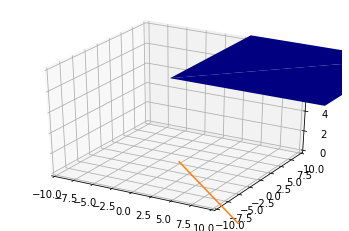

,Время с начала запуска,Состояние системы
0,0,OFF
1,1,ON
2,2,ON
3,3,ON
4,4,ON
5,5,ON
6,6,ON
7,7,ON
8,8,ON
9,9,ON


In [125]:
try:
    latitude = float(input("Введите широту(Москва - 55.7522): "))
except ValueError:
    latitude = None
try:
    longitude = float(input("Введите долготу(Москва - 37.6156): "))
except ValueError:
    longitude = None
try: 
    utc_offset = int(input("Введите временной сдвиг(Москва - 3 часа): "))
except ValueError:
    utc_offset = None
try:
    hour = int(input("Введите время в часах: "))
except ValueError:
    hour = None
try:
    minute = int(input("Введите время в минутах: "))
except ValueError:
    minute = None
SEA = math.radians(getSEA(latitude, longitude, utc_offset, hour, minute))
AZ = math.radians(getAZ(latitude, longitude, utc_offset, hour, minute))
sun = Sun(SEA, AZ)
cloude = Cloude()
flower = Flower()
lamp = Lamp()
time_on = list()
status = list()
print("Коордитаны солнца: {}".format(sun.position()))
print("Координаты центра облака: {}".format(cloude.center_position()))
for t in range(10):
    time_on.append(t)
    status.append(lamp.check())
    update_field(sun, flower)
    if(check_intersection(sun,cloude,flower) or sun.position()[2]<0):
        lamp.on()
    else:
        lamp.off()
        
    
    
    x = [cloude.x1, cloude.x2, cloude.x3, cloude.x4]
    y = [cloude.y1, cloude.y2, cloude.y3, cloude.y4]
    z = [cloude.z1, cloude.z2, cloude.z3, cloude.z4]
    fig = plt.figure()
    ax = fig.gca(projection = '3d')
    ax.plot_trisurf(x,y,z, cmap = cm.jet)
    ax.plot([flower.position()[0],sun.position()[0]],
            [flower.position()[1],sun.position()[1]], 
            [flower.position()[2],sun.position()[2]])
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    ax.set_zlim(0,10)
    plt.show()

    time.sleep(1)
df = pd.DataFrame({'Время с начала запуска': time_on, 'Состояние системы': status})
if(getpass.getuser() == "Snowfall"):
    df.to_excel('Desktop/МАИ/Архитектура информационных систем/ПЗ1/Отчет о работе ламы - 3D.xlsx')
else:
    df.to_excel('Desktop/Отчет о работе ламы - 3D.xlsx')
df.head(10)